# Final Project Report

#### STATS 102 Introduction to Data Science Session 1, 2023 Fall

---

# Project Title: Machine Learning for Predicting Crop Yield: A Study Based on 1990-2013 Crop Yield and Weather Data


- Yufan Gao (yg191@duke.edu)
- Jianing Tian (jt353@duke.edu)

## 1 Introduction

Write the introduction of your project here to make the reader understand what you set out to do and what you achieved.



(1) General introduction

(2) Problems and Models Description

(3) Expected Outcomes and Achievements

## 2 Background 

Write the relevant background information (the related work or state of the art in the area) about your project.

(1) Background information

(2) Innovation and Gaps

### 第一部分就是数据展示，分类模型，第二部分就是不同特征与yield的关系，还有哪些可以更有relation。第三部分是model selection & prediction。

## 3 Design and Implementation

# Part I: Data collection, preprocessing and cleaning 

In [1]:
#importing the basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#ingesting the datasets 
pest_df=pd.read_csv('pesticides.csv')
rain_df=pd.read_csv('rainfall.csv')
temp_df=pd.read_csv('temp.csv')
yield_df=pd.read_csv('yield.csv')
data_frames=[pest_df,rain_df,temp_df,yield_df]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
pest_df=pest_df.drop(['Unit','Domain','Element','Item'],axis=1)
pest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4349 entries, 0 to 4348
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Area    4349 non-null   object 
 1   Year    4349 non-null   int64  
 2   Value   4349 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 102.1+ KB


In [3]:
# Correct the Region issue of China
regions_to_rename = {
    'China, mainland': 'China',
    'China, Hong Kong SAR': 'China',
    'China, Macao SAR': 'China',
    'China, Taiwan Province of': 'China'
}

pest_df['Area'] = pest_df['Area'].replace(regions_to_rename)

# Display basic information about the cleaned dataframe
pest_df.info()

# Show a sample of the data after renaming
pest_df.sample(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4349 entries, 0 to 4348
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Area    4349 non-null   object 
 1   Year    4349 non-null   int64  
 2   Value   4349 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 102.1+ KB


,Area,Year,Value
2811,New Zealand,1992,3490.00
3630,Sudan (former),1991,1643.00
3618,Sri Lanka,2011,1290.31
3079,Peru,1990,3134.00
83,Antigua and Barbuda,1992,7.52


In [4]:
yield_df=yield_df.drop(['Domain Code','Domain','Area Code','Element Code','Item Code','Year Code','Unit'],axis=1)
yield_df.head()

,Area,Element,Item,Year,Value
0,Afghanistan,Yield,Maize,1961,14000
1,Afghanistan,Yield,Maize,1962,14000
2,Afghanistan,Yield,Maize,1963,14260
3,Afghanistan,Yield,Maize,1964,14257
4,Afghanistan,Yield,Maize,1965,14400


In [5]:
rain_df = rain_df.rename(index=str, columns={" Area": 'Area'})
# convert average_rain_fall_mm_per_year from object to float
rain_df['average_rain_fall_mm_per_year'] = pd.to_numeric(rain_df['average_rain_fall_mm_per_year'],errors = 'coerce')
rain_df = rain_df.dropna()
rain_df.head()

,Area,Year,average_rain_fall_mm_per_year
0,Afghanistan,1985,327.0
1,Afghanistan,1986,327.0
2,Afghanistan,1987,327.0
3,Afghanistan,1989,327.0
4,Afghanistan,1990,327.0


In [6]:
temp_df.rename(columns = {'year':'Year','country':'Area'},inplace = True)
temp_df.columns

Index(['Year', 'Area', 'avg_temp'], dtype='object')

In [7]:
# Merging our datasets into 1 single dataframe
yield_df2 = pd.read_csv('yield_df.csv')
# Perform the chained merging of DataFrames
df2 = yield_df.merge(pest_df, on=['Year', 'Area'])\
                   .merge(rain_df, on=['Year', 'Area'])\
                   .merge(temp_df, on=['Year', 'Area'])
print(df2.columns)
df2.info()

Index(['Area', 'Element', 'Item', 'Year', 'Value_x', 'Value_y',
       'average_rain_fall_mm_per_year', 'avg_temp'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53266 entries, 0 to 53265
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           53266 non-null  object 
 1   Element                        53266 non-null  object 
 2   Item                           53266 non-null  object 
 3   Year                           53266 non-null  int64  
 4   Value_x                        53266 non-null  int64  
 5   Value_y                        53266 non-null  float64
 6   average_rain_fall_mm_per_year  53266 non-null  float64
 7   avg_temp                       53266 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 3.7+ MB


In [8]:
df2.rename(columns={'Value_y':'pesticides_tonnes','Value_x':'yield_hg/ha','average_rain_fall_mm_per_year':'rainfall_mm'},inplace=True)
df2=df2.drop('Element',axis=1)
yield_df2=yield_df2.drop('Unnamed: 0',axis=1)
print(yield_df2.columns)
print(df2.columns)

Index(['Area', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year',
       'pesticides_tonnes', 'avg_temp'],
      dtype='object')
Index(['Area', 'Item', 'Year', 'yield_hg/ha', 'pesticides_tonnes',
       'rainfall_mm', 'avg_temp'],
      dtype='object')


In [9]:
df2.shape, yield_df2.shape # yield_df2 is the original yield_df

((53266, 7), (28242, 7))

In [10]:
df2.describe()

,Year,yield_hg/ha,pesticides_tonnes,rainfall_mm,avg_temp
count,53266.000000,53266.000000,5.326600e+04,53266.000000,53266.000000
mean,2001.492847,82558.482428,1.767115e+05,912.253952,17.249831
std,7.057729,76036.050538,4.382047e+05,574.820756,6.782145
min,1990.000000,50.000000,4.000000e-02,51.000000,1.300000
25%,1995.000000,26092.000000,7.948250e+01,645.000000,12.660000
50%,2001.000000,49868.000000,9.228000e+03,645.000000,17.180000
75%,2008.000000,140130.500000,4.868788e+04,1083.000000,22.420000
max,2013.000000,501412.000000,1.806000e+06,3240.000000,30.650000


In [11]:
df2.nunique()

Area                   102
Item                    10
Year                    23
yield_hg/ha          11692
pesticides_tonnes     1739
rainfall_mm            101
avg_temp              2025
dtype: int64


The final dataframe starts from 1990 and ends in 2013, that's 23 years worth of data for 102 countries.

# Part II: Data Analysis

In [12]:
num_cols = [i for i in df2.columns if (df2[i].dtype == 'float64' or df2[i].dtype == 'int64')]
cat_cols = [i for i in df2.columns if (i not in num_cols) and i != 'yield_hg/ha']  
print(num_cols)
print(cat_cols)

['Year', 'yield_hg/ha', 'pesticides_tonnes', 'rainfall_mm', 'avg_temp']
['Area', 'Item']


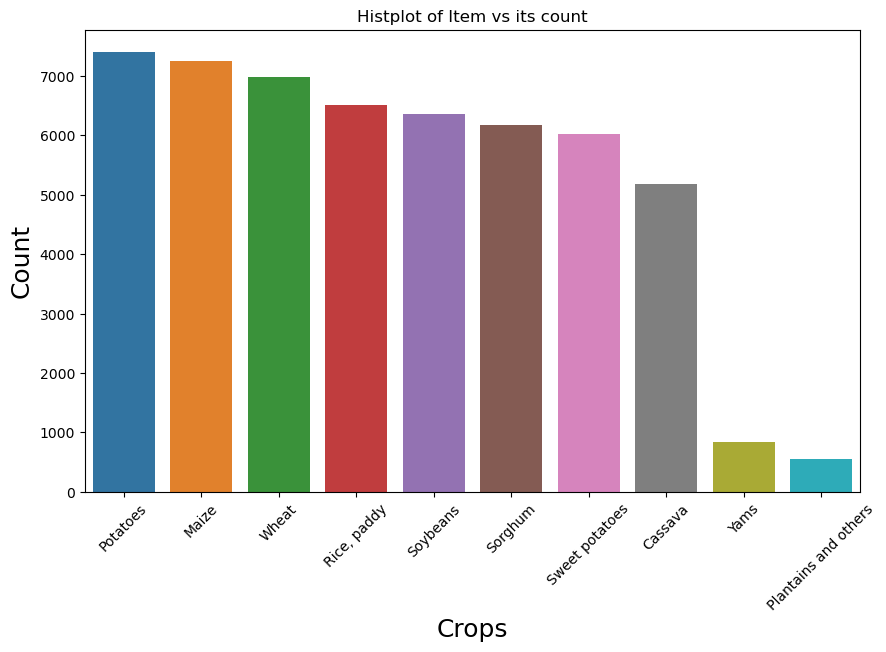

In [13]:
sorted_order = df2['Item'].value_counts().index
plt.figure(figsize=(10,6))
sns.countplot(x='Item', data=df2, order=sorted_order)
plt.title('Histplot of Item vs its count')
plt.xlabel('Crops', fontsize=18, loc='center')
plt.ylabel('Count', fontsize=18, loc='center')
plt.xticks(rotation=45)
plt.show()

In [15]:
df2['Area'].nunique() 
df2.groupby(['Area'],sort=True)['yield_hg/ha'].sum().nlargest(10)

Area
China             2221419920
India              327420324
Brazil             167550306
Mexico             130788528
Japan              124470912
Australia          109111062
Pakistan            73897434
Indonesia           69193506
United Kingdom      55419990
Turkey              52263950
Name: yield_hg/ha, dtype: int64

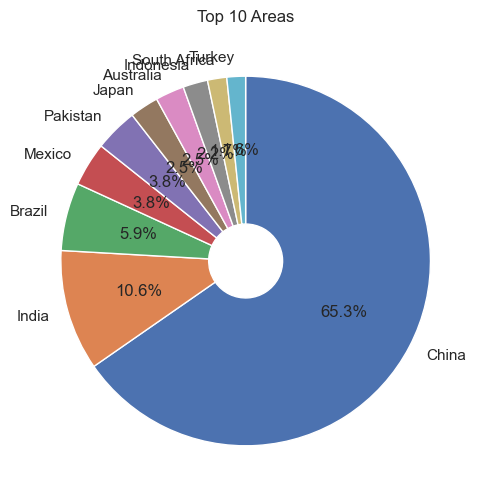

In [25]:
top_10_areas = df2['Area'].value_counts().nlargest(10)
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.pie(top_10_areas, labels=top_10_areas.index, autopct='%.1f%%', startangle=90, counterclock=False, wedgeprops=dict(width=0.8))
plt.title('Top 10 Areas')
plt.ylabel('')
plt.show()


In [21]:
df2.groupby(['Item','Area'],sort=True)['yield_hg/ha'].sum().nlargest(10)

Item            Area 
Sweet potatoes  China    626122512
Cassava         China    488224496
Potatoes        China    448875072
Rice, paddy     China    195523664
Maize           China    159135640
Cassava         India    142810624
Wheat           China    127511152
Sorghum         China    123438360
Potatoes        India     92122514
Soybeans        China     52589024
Name: yield_hg/ha, dtype: int64

China has the highest yield production in the dataset. India is the highest for production of cassava and potatoes. Potatoes seems to be the dominated crop in the dataset.

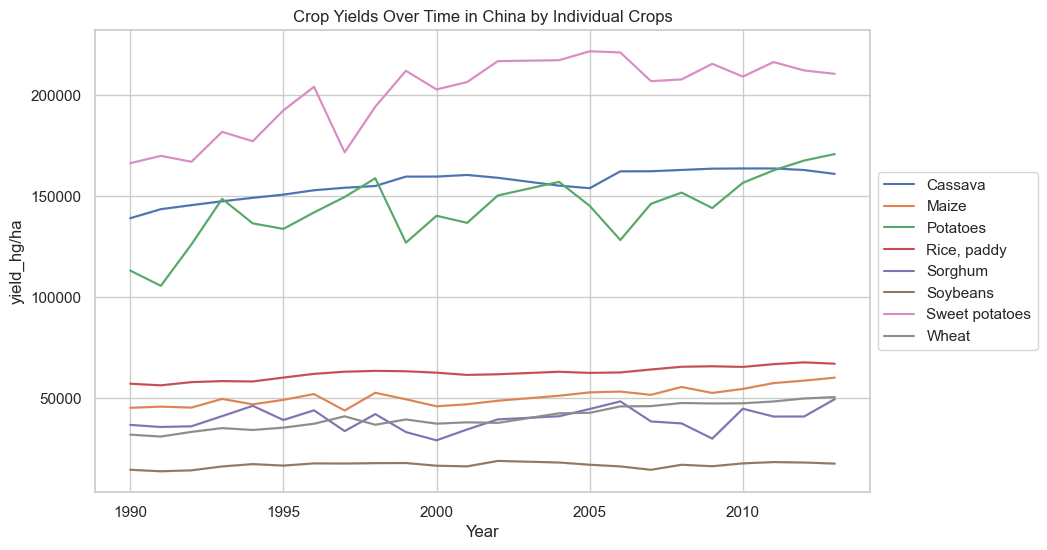

In [21]:
df_China = df2[df2['Area'] == 'China']
plt.figure(figsize=(10, 6)) 
for crop in df_China['Item'].unique():
    crop_data = df_China[df_China['Item'] == crop]
    sns.lineplot(data=crop_data, x='Year', y='yield_hg/ha', label=crop)
plt.title('Crop Yields Over Time in China by Individual Crops')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

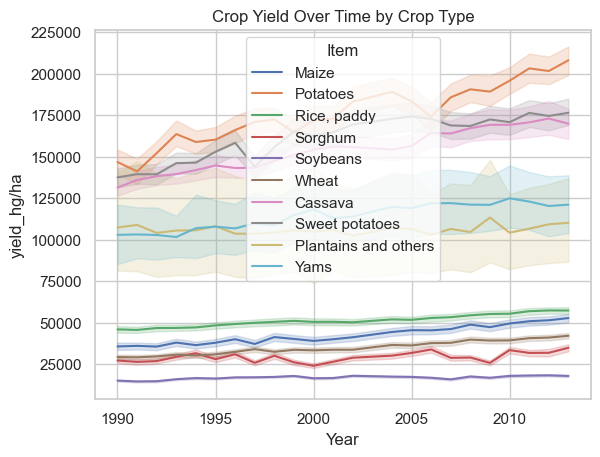

In [22]:
sns.lineplot(x='Year', y='yield_hg/ha', hue ='Item', data=df2) # hue means color
plt.title('Crop Yield Over Time by Crop Type')
plt.show()

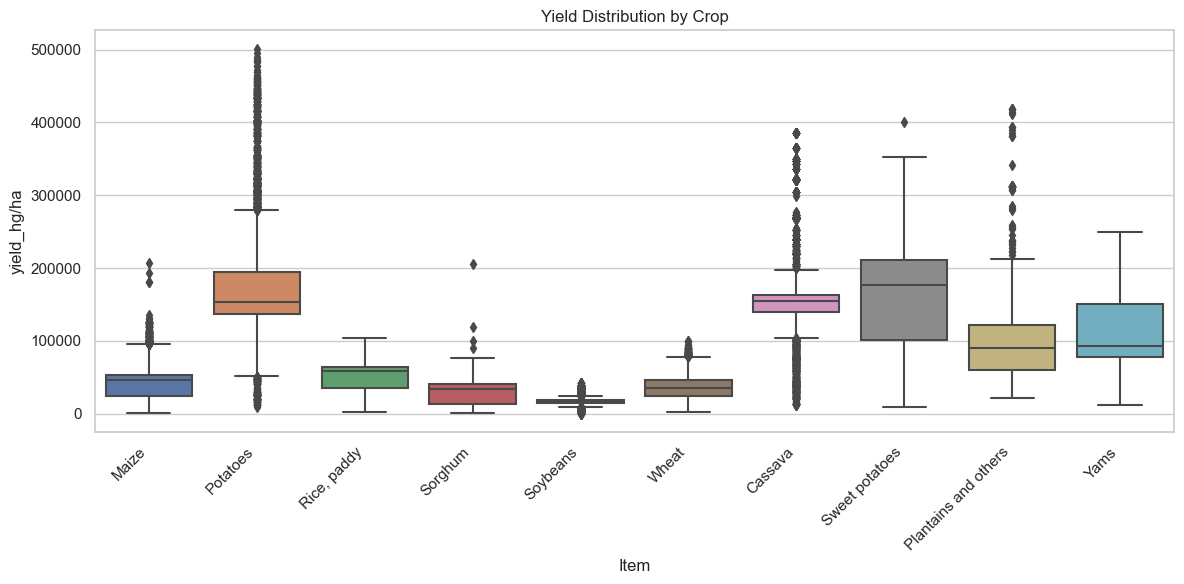

In [23]:
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Item', y='yield_hg/ha', data=df2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Yield Distribution by Crop')
plt.tight_layout()
plt.show()

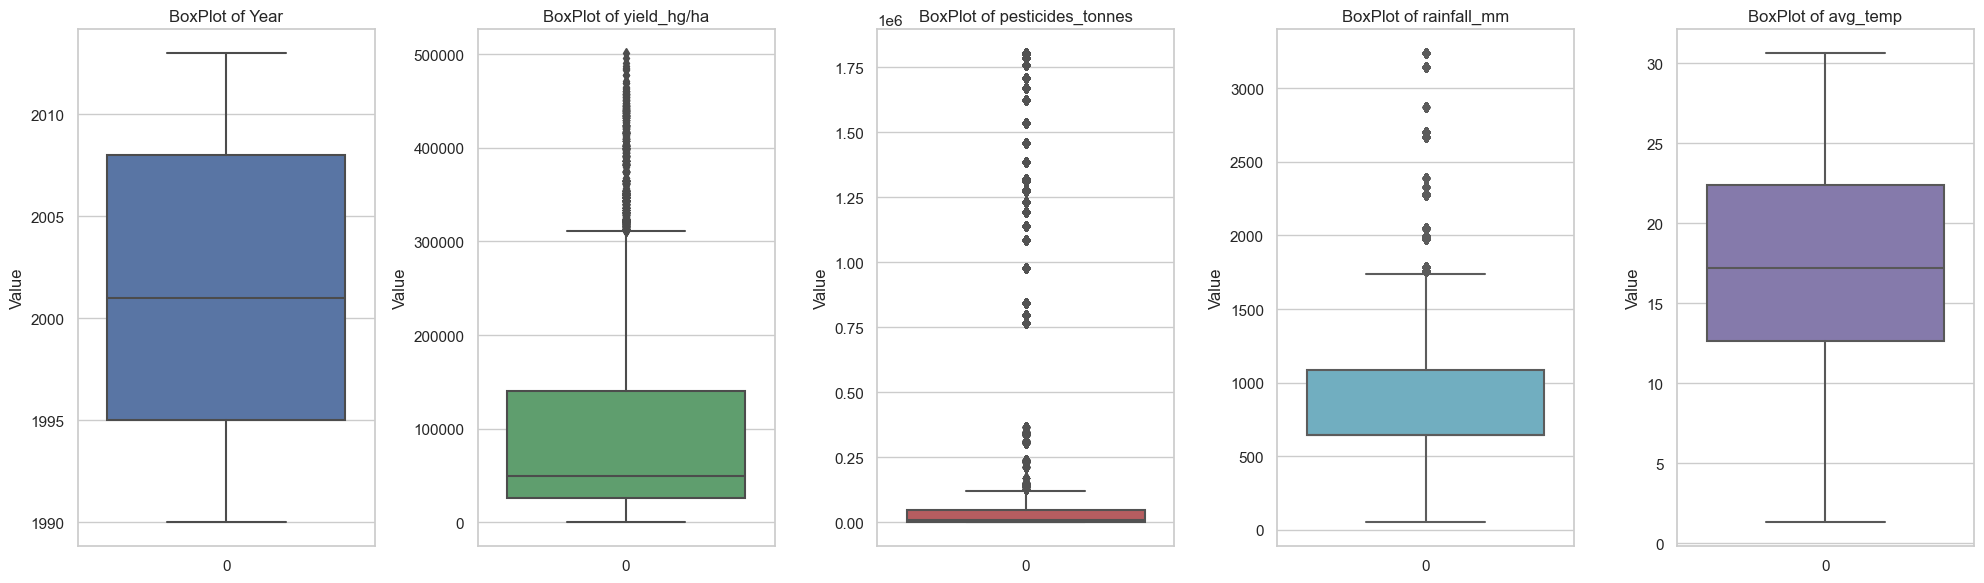

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ['b', 'g', 'r', 'c', 'm', 'y']
plt.figure(figsize=(20, 6))
for i, col in enumerate(num_cols):
    plt.subplot(1, len(num_cols), i+1)
    sns.boxplot(data=df2[col], color=colors[i % len(colors)])
    plt.title(f'BoxPlot of {col}')
    plt.ylabel('Value')
plt.tight_layout()
plt.show()

The boxplot above demonstrates the general rule and conclusion for all crops in various areas, which might have few realistic meanings. This could be excluded if necessary.

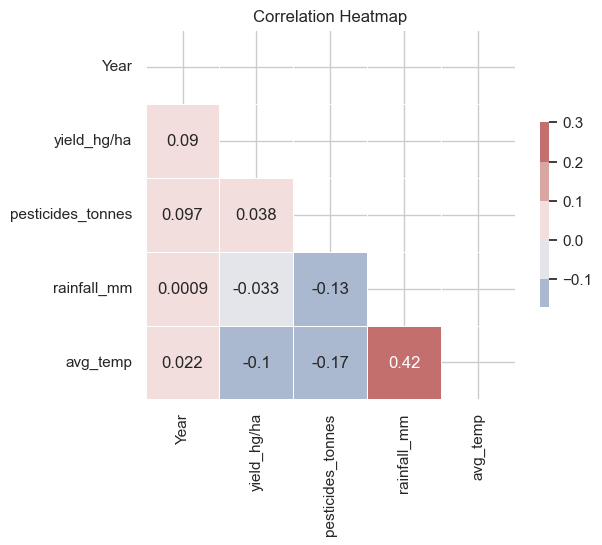

In [27]:
corr_matrix = df2.corr()
cmap = sns.color_palette("vlag")
sns.heatmap(corr_matrix, cmap = cmap,annot=True, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},mask=np.triu(corr_matrix))
plt.title('Correlation Heatmap')
plt.show()

A moderate, positive correlation of 0.42 was observed between average annual rainfall and average temperature. This suggests that as temperature or rainfall increases, the other variable also tends to increase, although the relationship is not strong. while the correlation is statistically significant (p<0.05), indicating that the relationship is unlikely to be due to random chance, it does not imply causation. The practical significance of this correlation depends on the context and the specific variables involved.

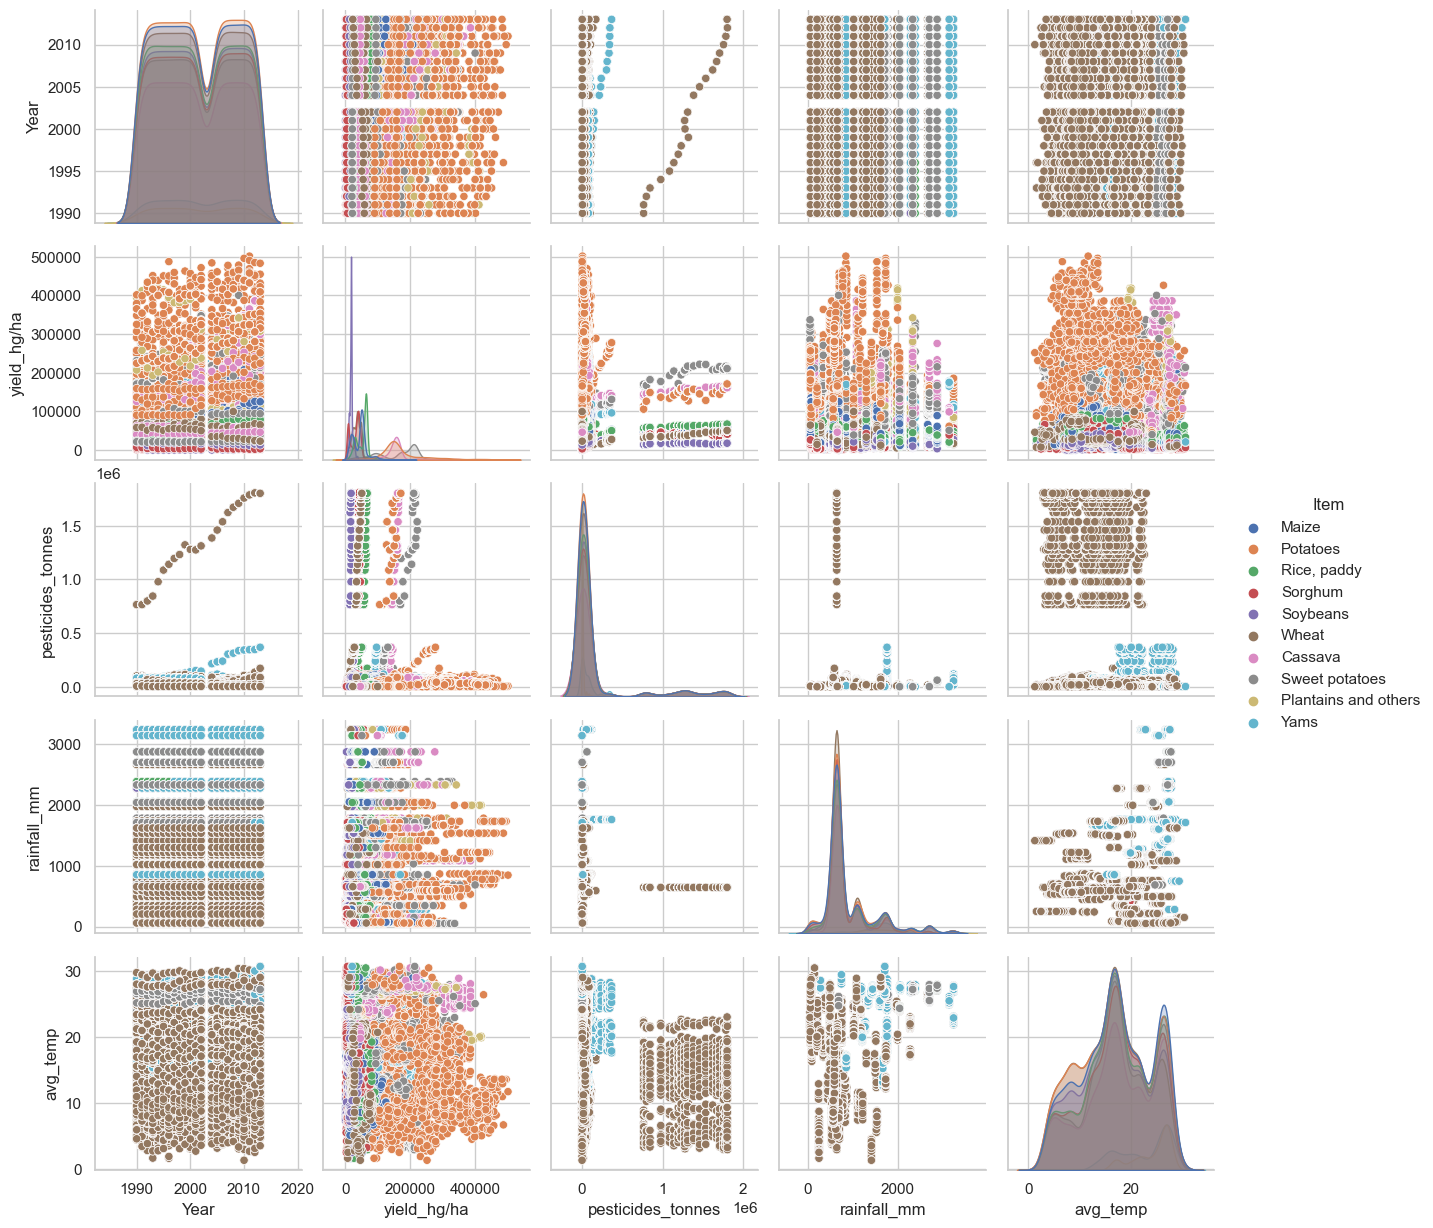

In [26]:
sns.pairplot(df2, hue='Item') #pairplot means scatterplot
plt.show()

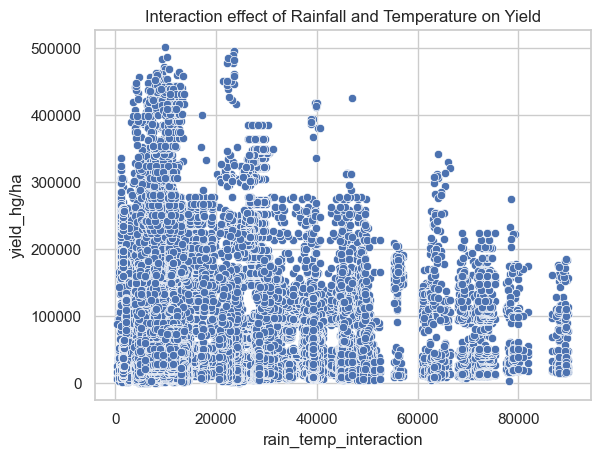

In [28]:
# interaction effect of rainfall and temperature on yield
df2['rain_temp_interaction'] = df2['rainfall_mm'] * df2['avg_temp']
sns.scatterplot(x='rain_temp_interaction', y='yield_hg/ha', data=df2)
plt.title('Interaction effect of Rainfall and Temperature on Yield')
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


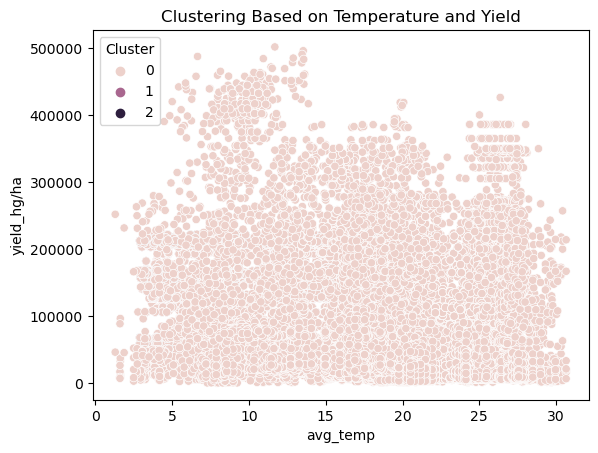

In [35]:
# KMeans Clustering, to see if there are any natural clusters in the data
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
df2_clustered = df2.drop(['Area', 'Item', 'Year'], axis=1)
kmeans.fit(df2_clustered)
df2['Cluster'] = kmeans.labels_
sns.scatterplot(x='avg_temp', y='yield_hg/ha', hue='Cluster', data=df2)
plt.title('Clustering Based on Temperature and Yield')
plt.show()

# Part III: Model Selection and Prediction

## Backward Stepwise Selection

In [14]:
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant
import statsmodels.api as sm
np.random.seed(0)

# Extract dependent and independent variables
y = df2['yield_hg/ha']
X = df2[['Year', 'pesticides_tonnes', 'rainfall_mm', 'avg_temp']]
X_with_const = add_constant(X)

# Initialize variables for backward elimination
remaining_features = list(X_with_const.columns)
alpha = 0.05  # Significance level
model = OLS(y, X_with_const[remaining_features]).fit()

# Perform backward elimination
while True:
    max_p_value = max(model.pvalues)
    worst_feature = model.pvalues.idxmax()
    if max_p_value > alpha:
        remaining_features.remove(worst_feature)
        model = OLS(y, X_with_const[remaining_features]).fit()
    else:
        break

# Re-fit the final model with remaining features
final_model = OLS(y, X_with_const[remaining_features]).fit()
coefficients = final_model.params
std_dev = X_with_const[remaining_features].std()
std_co = coefficients / std_dev

sorted_std_co = std_co.abs().sort_values(ascending=False)
sorted_std_co

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


const                         inf
avg_temp             1.776826e+02
Year                 1.390550e+02
rainfall_mm          3.088623e-03
pesticides_tonnes    5.091966e-09
dtype: float64

The standardized coefficients provide a way to compare the relative importance of variables in the model. A higher absolute value of the standardized coefficient indicates a stronger relationship with the dependent variable, when all other predictors are held constant.

Average Temperature (avg_temp): With a standardized coefficient of approximately 177.68, average temperature appears to be the most influential variable in predicting crop yield. A one-standard-deviation increase in average temperature is associated with a large 177.68-standard-deviation increase in crop yield, assuming all other variables are held constant. This indicates a strong linear relationship between average temperature and crop yield in the given dataset.

Year (Year): The variable 'Year' also appears to be influential, with a standardized coefficient of approximately 139.06. This suggests that the year also has a strong positive linear relationship with crop yield, holding all other variables constant.

Rainfall (rainfall_mm): With a standardized coefficient of 0.0031, rainfall appears to have a negligible linear influence on crop yield in comparison to the other variables.

Pesticides (pesticides_tonnes): With a coefficient close to zero (5.09×10^−9), the amount of pesticides used appears to have an almost negligible linear impact on crop yield, all else being equal.

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X, y = df2.drop(['Year', 'yield_hg/ha','pesticides_tonnes'], axis=1), df2['yield_hg/ha']

# One-hot encode and standardize the data
X = StandardScaler().fit_transform(pd.get_dummies(X, columns=cat_cols, drop_first=True))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, shuffle=True)

print(X_train.shape, X_test.shape) 

(42612, 112) (10654, 112)


Cross-validation offers a robust method to evaluate the predictive performance of your machine learning model. It helps in ensuring that the model generalizes well to new, unseen data, thereby mitigating the risk of overfitting.

In [18]:
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestRegressor

# model = RandomForestRegressor()
# cv_scores = cross_val_score(model, X_train, y_train, cv=5)
# print("5-fold cross-validation scores:", cv_scores)
# mcs = cv_scores.mean()
# sd_cv_score = cv_scores.std()
# print("Mean CV score:", mcs)
# print("Standard deviation of CV scores:", sd_cv_score)

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    # 'max_depth': [None, 10, 20, 30, 40, 50],
    # 'min_samples_split': [2, 5, 10],
}

# Create the base model
rf = RandomForestRegressor()

# Initialize the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

/opt/anaconda3/lib/python3.9/multiprocessing/resource_tracker.py:96: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '
Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


? Best_score no refers to R-square. Mean CV score = best score

In [23]:
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor

# Initialize model parameters
model_params = {
    'Linear Regression': {},
    'Ridge Regression': {'alpha': [0.1, 1.0, 10.0]},
    'Lasso Regression': {'alpha': [0.1, 1.0, 10.0]},
    'XGBoost_Regressor': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.5, 1.0]}
}

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'XGBoost_Regressor': XGBRegressor(),
}

results = {}

# Validate the existence and dimensions of X_train and y_train
try:
    n = len(y_train)
    k = X_train.shape[1]
except NameError:
    raise Exception("Variables X_train and y_train must be defined")

# Perform 5-fold cross-validation, hyperparameter tuning, and calculate adjusted R^2
for name, model in tqdm(models.items()):
    grid_search = GridSearchCV(model, model_params[name], cv=5, scoring=make_scorer(r2_score))
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    
    adjusted_r2 = 1 - ((1 - best_score) * (n - 1) / (n - k - 1))
    
    results[name] = {
        'best_score': best_score,
        'best_params': grid_search.best_params_,
        'adjusted_R^2': adjusted_r2
    }

# Display the results
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  best_score: {metrics['best_score']}")
    print(f"  best_params: {metrics['best_params']}")
    print(f"  adjusted_R^2: {metrics['adjusted_R^2']}\n")


/opt/anaconda3/lib/python3.9/multiprocessing/resource_tracker.py:96: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '
  0%|                                                     | 0/4 [00:00<?, ?it/s]Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

 25%|███████████▎                                 | 1/4 [00:00<00:02,  1.38it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


 50%|██████████████████████▌                      | 2/4 [00:01<00:00,  2.07it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.488e+12, tolerance: 1.972e+10
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.839e+12, tolerance: 1.961e+10
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.513e+12, toleranc

[CV] END ....................................n_estimators=50; total time=   7.4s
[CV] END ....................................n_estimators=10; total time=   1.4s
[CV] END ....................................n_estimators=50; total time=   7.1s
[CV] END ....................................n_estimators=10; total time=   1.4s
[CV] END ....................................n_estimators=50; total time=   7.3s


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.690e+11, tolerance: 1.964e+10
  model = cd_fast.enet_coordinate_descent(


[CV] END ....................................n_estimators=10; total time=   1.4s
[CV] END ...................................n_estimators=100; total time=  12.8s
[CV] END ....................................n_estimators=10; total time=   1.5s
[CV] END ...................................n_estimators=100; total time=  12.9s
[CV] END ....................................n_estimators=10; total time=   1.5s
[CV] END ...................................n_estimators=100; total time=  13.1s
[CV] END ....................................n_estimators=50; total time=   7.2s
[CV] END ...................................n_estimators=100; total time=  11.0s
[CV] END ....................................n_estimators=50; total time=   7.3s
[CV] END ...................................n_estimators=100; total time=  10.9s


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.219e+10, tolerance: 1.970e+10
  model = cd_fast.enet_coordinate_descent(
100%|████████████████████████████████████████████| 4/4 [07:46<00:00, 116.72s/it]

Linear Regression:
  best_score: 0.7764968575695284
  best_params: {}
  adjusted_R^2: 0.775907847193938

Ridge Regression:
  best_score: 0.7764962648124507
  best_params: {'alpha': 10.0}
  adjusted_R^2: 0.7759072528747344

Lasso Regression:
  best_score: 0.7764991208043572
  best_params: {'alpha': 10.0}
  adjusted_R^2: 0.7759101163931967

XGBoost_Regressor:
  best_score: 0.9525122416195545
  best_params: {'learning_rate': 0.5, 'n_estimators': 200}
  adjusted_R^2: 0.9523870944645954



## Normalization & Run SVM

In [18]:
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

model_params = {
    'SVR': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }
}

models = {
    'SVR': SVR()
}

results = {}

# Validate the existence and dimensions of X_train and y_train
try:
    n = len(y_train)
    k = X_train.shape[1]
except NameError:
    raise Exception("Variables X_train and y_train must be defined")

# Normalize variables to 0-1 scale
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)

# Convert y_train to a NumPy array and reshape
y_train_array = y_train.values.reshape(-1, 1)
y_train_scaled = scaler_y.fit_transform(y_train_array).flatten()

In [19]:
X_train_scaled

array([[0.18626529, 0.54310051, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01285669, 0.90732538, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.53621825, 0.60613288, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.32361242, 0.83202726, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.15145814, 0.59386712, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.18626529, 0.5229983 , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [20]:
y_train_scaled

array([0.08179519, 0.07630415, 0.06621164, ..., 0.05179092, 0.56906786,
       0.08393137])

In [21]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {}
svm_model = SVR()

# Perform randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    svm_model, param_distributions=param_dist, n_iter=10,
    cv=5, scoring='r2', random_state=42, n_jobs=1
)

random_search.fit(X_train_scaled, y_train_scaled)
best_svm_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best SVM Model:")
print(f"  Best Parameters: {best_params}")
print(f"  Best R^2 Score: {best_score}")

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best SVM Model:
  Best Parameters: {}
  Best R^2 Score: 0.8621774718929798


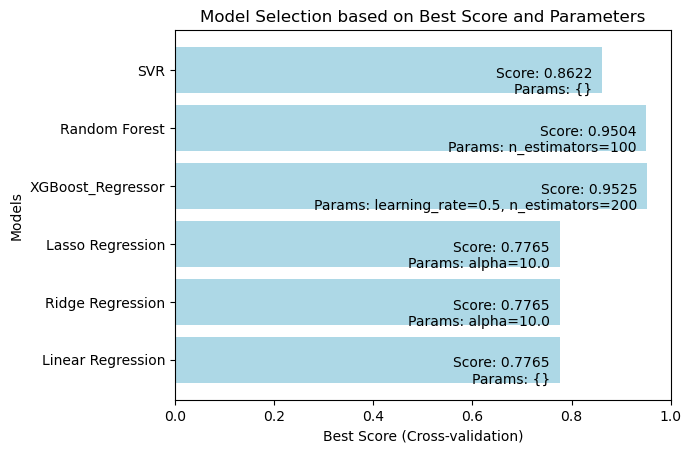

In [39]:
import matplotlib.pyplot as plt

model_names = list(results.keys())
best_scores = [results[model]['best_score'] for model in model_names]
best_params = [results[model]['best_params'] for model in model_names]

# Manually add the results for Random Forest and SVR
model_names += ['Random Forest', 'SVR']
best_scores += [0.950395922670015, 0.8621774718929798]
best_params += [{'n_estimators': 100}, {}]

bars = plt.barh(model_names, best_scores, color='lightblue')

for bar, model, score, params in zip(bars, model_names, best_scores, best_params):
    best_params_str = ', '.join([f'{key}={value}' for key, value in params.items()]) if params else '{}'
    plt.text(bar.get_width() - 0.02, bar.get_y() + bar.get_height() / 4,
             f'Score: {round(score, 4)}\nParams: {best_params_str}',
             va='center', ha='right', color='black')

plt.xlabel('Best Score (Cross-validation)')
plt.ylabel('Models')
plt.title('Model Selection based on Best Score and Parameters')

plt.show()

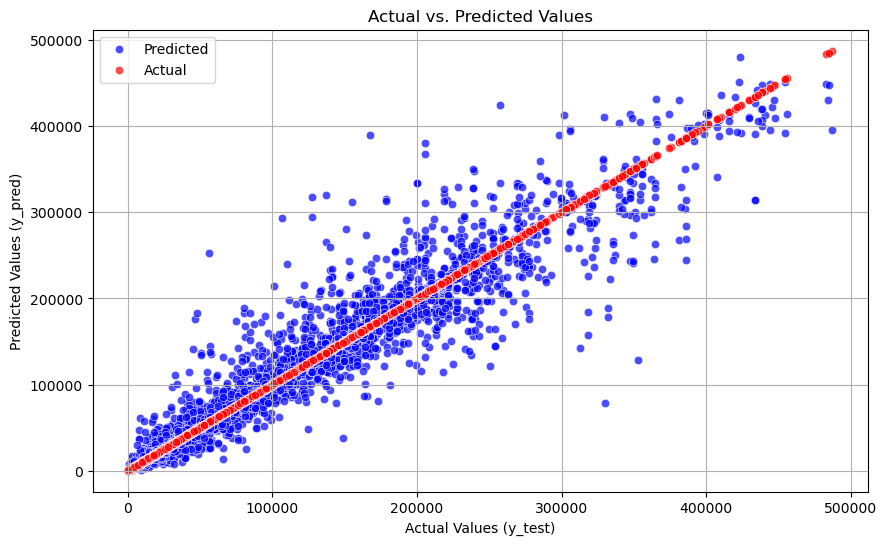

In [16]:
from sklearn.ensemble import RandomForestRegressor
best_model=RandomForestRegressor(n_estimators=100)
best_model.fit(X_train,y_train)
y_pred=best_model.predict(X_test)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color='blue', label='Predicted')
sns.scatterplot(x=y_test, y=y_test, alpha=0.7, color='red', label='Actual')
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Actual vs. Predicted Values")
plt.grid(True)
plt.legend()
plt.show()

? Why xgboost has the highest best-score? what is the idea/principle behind the result? Why we choose random forest at last?

## 4 Results

## 5 Conclusions 

(1) Conclusions

(2) Limitation

## 6 Individual Contribution 

Write the individual contribution here.

## References

Everything you cite from other sources should be properly referenced. 

APA style is used here: https://irsc.libguides.com/apa

## Appendix

Code or something else you want to put in the appendix.